In [2]:
import numpy as np
import random
import math
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# 建立環境 (Environment)
# 在多臂拉霸機中的環境就是拉桿，以 SlotArm類別 建立拉桿
# 拉桿的機率是由我們所指定
class SlotArm():
    def __init__(self, p): # p: 拉桿釋出代幣的機率
        self.p = p
    def draw(self):
        if self.p > random.random():
            return 1.0
        else:
            return 0.0

In [4]:
# 定義 epsilon-greedy class: 方便我們進行 epsilon-greedy的計算
class EpsilonGreedy():
    # 初始化 epsilon-greedy
    def __init__(self, epsilon):
        self.epsilon = epsilon # epsilon：進行 explore; 1-epsilon：進行 exploit
    
    # 利用 np.zeros() 將試驗次數與價值歸零
    def initialize(self, n_arms):
        self.n = np.zeros(n_arms) # 各拉桿的試驗次數歸零
        self.v = np.zeros(n_arms) # 各拉桿的價值歸零
    
    # 選擇拉桿
    def select_arm(self):
        if self.epsilon > random.random():
            return np.random.randint(0, len(self.v)) # 隨機選擇拉桿進行探索
        else:
            return np.argmax(self.v) # 選擇價值最高的拉桿
    
    # 更新所選拉桿的價值
    def update(self, chosen_arm, reward, t):
        # 將所選拉桿的試驗次數加 1
        self.n[chosen_arm] += 1
        # 更新所選拉桿的價值
        n = self.n[chosen_arm]
        v = self.v[chosen_arm]
        self.v[chosen_arm] = ((n-1) / float(n)) * v + (1 / float(n)) * reward
    
    # 畫圖用
    def label(self):
        return 'ε-greedy(' + str(self.epsilon)+')'
    

In [5]:
# 定義 UCB1 algo.
class UCB1():
    # 利用 np.zeros() 將試驗次數、成功次數與價值歸零
    def initialize(self, n_arms):
        self.n = np.zeros(n_arms) # 各拉桿的試驗次數
        self.w = np.zeros(n_arms) # 各拉桿的成功次數
        self.v = np.zeros(n_arms) # 各拉桿的價值
        
    # 選擇拉桿
    def select_arm(self):
        for i in range(len(self.n)):
            if self.n[i] == 0:
                return i # 先將所有拉桿都拉過一次，讓 n 不為 0 -----------------------????????????? i = 0
        
        return np.argmax(self.v) # 選擇價值最高的拉桿
    
    # 更新所有拉桿的價值
    def update(self, chosen_arm, reward, t):
        self.n[chosen_arm] += 1
        if reward == 1.0:
            self.w[chosen_arm] += 1 # 成功時將所選拉桿的成功次數加 1
        for i in range(len(self.n)):
            if self.n[i] == 0:
                return # 當有試驗次數為 0 的拉桿存在時，不更新價值
        for i in range(len(self.v)): # 更新所有拉桿的價值
            self.v[i] = self.w[i] / self.n[i] + (2 * math.log(t) / self.n[i]) ** 0.5
            
    # 畫圖用
    def label(self):
        return 'ucb1'

In [6]:
# 定義模擬範例的函式
# 建立 play()函式 來進行範例的模擬，並取得遊戲進行的回合數和 reward
# 接著將這兩項資訊存成 history
def play(algo, arms, num_sims, num_time):
    times = np.zeros(num_sims * num_time)
    rewards = np.zeros(num_sims * num_time)
    
    # 開始進行第 1 次、第 2 次... 第 num_sims次範例模擬
    for sim in range(num_sims):
        algo.initialize(len(arms)) # 初始化演算法
        
        # 開始每一次模擬的第 1 個、第 2 個... 第 num_time個回合
        for time in range(num_time):
            
            index = sim * num_time + time # 計算索引
            
            times[index] = time + 1
            chosen_arm = algo.select_arm() # 使用指定的 algo 選擇拉桿
            reward = arms[chosen_arm].draw() # 計算 reward
            rewards[index] = reward
            
            algo.update(chosen_arm, reward, time+1)
            
    return [times, rewards]

        times  rewards
0         1.0      0.0
1         2.0      1.0
2         3.0      1.0
3         4.0      0.0
4         5.0      0.0
...       ...      ...
249995  246.0      1.0
249996  247.0      1.0
249997  248.0      1.0
249998  249.0      1.0
249999  250.0      1.0

[250000 rows x 2 columns]
        times  rewards
0         1.0      0.0
1         2.0      0.0
2         3.0      1.0
3         4.0      0.0
4         5.0      1.0
...       ...      ...
249995  246.0      1.0
249996  247.0      1.0
249997  248.0      1.0
249998  249.0      1.0
249999  250.0      0.0

[250000 rows x 2 columns]


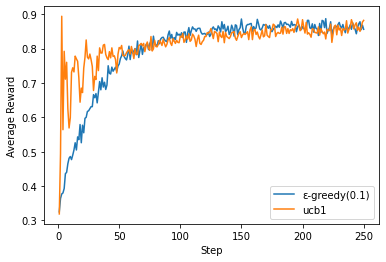

In [7]:
# 執行主程式並繪製圖形
# 1. 建立 3 支拉桿，釋出代幣的機率指定為 0.3、0.5 和 0.9
# 2. 建立演算法
# 3. 進行遊戲模擬
# 4. 繪製圖形

# Step01 建立拉桿
arms = (SlotArm(0.3), SlotArm(0.5), SlotArm(0.9))

# Step02 建立演算法
algos = (EpsilonGreedy(0.1), UCB1())

# Step03 進行遊戲模擬
for algo in algos:
    results = play(algo, arms, 1000, 250)
    
    # Step04 繪製圖形
    df = pd.DataFrame({'times':results[0], 'rewards':results[1]})
    print(df)
    mean = df['rewards'].groupby(df['times']).mean() # 計算每回合的平均 reward
    
    plt.plot(mean, label = algo.label())
    
# 繪製圖形
plt.xlabel('Step')
plt.ylabel('Average Reward')
plt.legend(loc='best')
plt.show()